This is a quick sample of basic Python operations to import data, clean them a little bit and then make some quick analytcal operations.

The aim of this analysis is to see what determines the area of a fire among the variables.

In [1]:
import numpy
import pandas
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import seaborn


dataset = "forestfires.csv"
fire_dataframe = pandas.read_csv(dataset, sep = ",")

Now, a quick analysis of the dataframe to see if it's well behaved

Dataframe general information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None

Dataframe contains NaNs?
False

Number of NaN entries
0

First rows:
   X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  

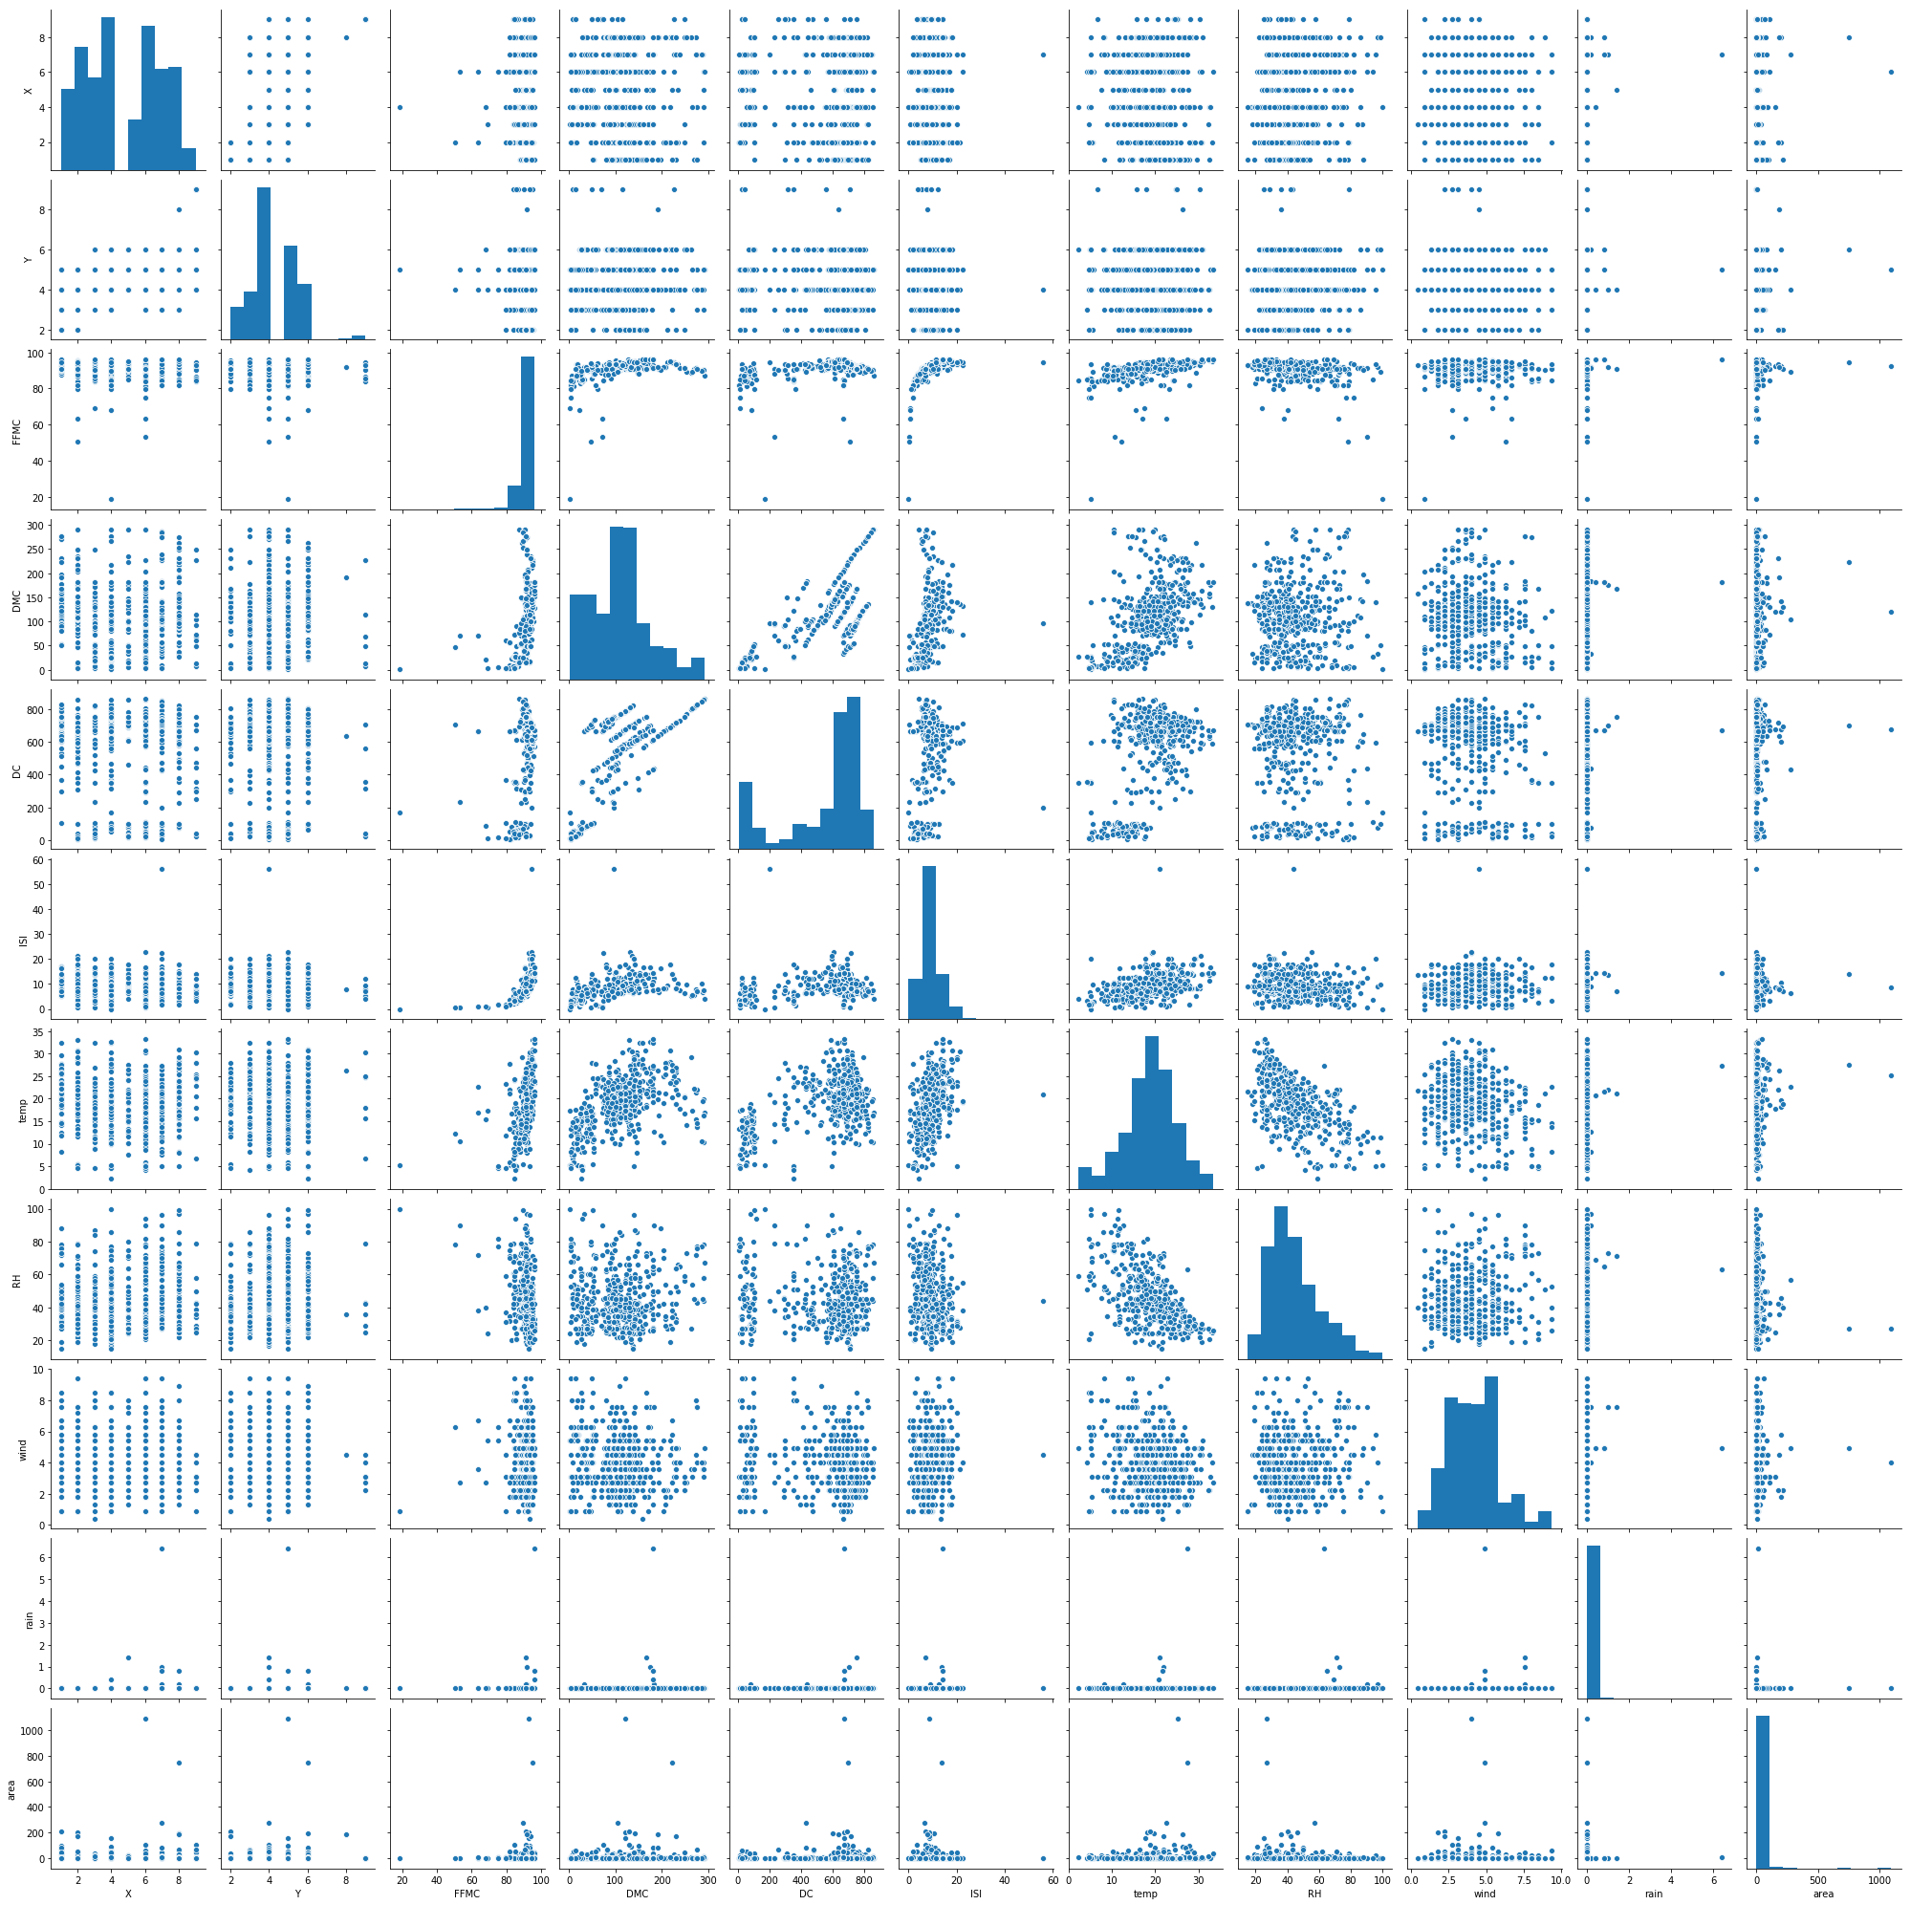

In [2]:
# inspect dataframe size
print("Dataframe general information:")
print(fire_dataframe.info())
# inspect if there are NaNs
print("\nDataframe contains NaNs?")
print(fire_dataframe.isnull().values.any())
print("\nNumber of NaN entries")
print(fire_dataframe.isnull().values.sum())
# inspect first rows
print("\nFirst rows:")
print(fire_dataframe.head(10))
# inspect dataframe summary
print("\nDataframe sumary:")
print(fire_dataframe.describe())
# quick scatterplots of unprocessed data
print("\nVisual inspection of data")
print(seaborn.pairplot(fire_dataframe))
# inspect correlations between data
print("\nInspection of correlations")
print(fire_dataframe.corr())



As an extra, I make plots of the distribution of categorical variablemonth

plot of fires by month
AxesSubplot(0.125,0.125;0.775x0.755)


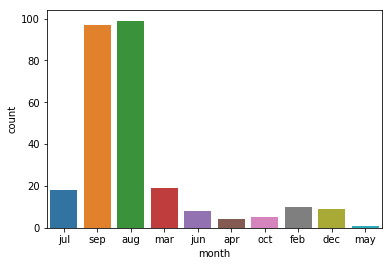

In [11]:
print("plot of fires by month")
plot2 = seaborn.countplot(x = "month", data = fire_dataframe)
print(plot2)


The dataframe has no NaNs, but there are some problems. First the "rain" and "area" are highly skewed toward zero. Secondly, the area variable seems to have not correlations with the other variables, which suggests that predictions may be unlikely.

To see if this is the case, let's first preprocess the data. As starting point, I will focus only on cases where the total alrea is greater than 0. This is a gross simplification, but it will give me a sense of the most significant fires.  I also convert the area into the log_area because it allows to deal better with the spread in area size.

Also, I plot how fires are distributed according to months and days of the weeks.


first rows:
     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  log_area
138  9  9   jul  tue  85.8   48.3  313.4   3.9  18.0  42   2.7   0.0 -1.021651
139  1  4   sep  tue  91.0  129.5  692.6   7.0  21.7  38   2.2   0.0 -0.843970
140  2  5   sep  mon  90.9  126.5  686.5   7.0  21.9  39   1.8   0.0 -0.755023
141  1  2   aug  wed  95.5   99.9  513.3  13.2  23.3  31   4.5   0.0 -0.597837
142  8  6   aug  fri  90.1  108.0  529.8  12.5  21.2  51   8.9   0.0 -0.494296
143  1  2   jul  sat  90.0   51.3  296.3   8.7  16.6  53   5.4   0.0 -0.342490
144  2  5   aug  wed  95.5   99.9  513.3  13.2  23.8  32   5.4   0.0 -0.261365
145  6  5   aug  thu  95.2  131.7  578.8  10.4  27.4  22   4.0   0.0 -0.105361
146  5  4   mar  mon  90.1   39.7   86.6   6.2  13.2  40   5.4   0.0 -0.051293
147  8  3   sep  tue  84.4   73.4  671.9   3.2  24.2  28   3.6   0.0 -0.040822

dataframe sumary:
                X           Y        FFMC         DMC          DC         ISI  \
count  270.000000 

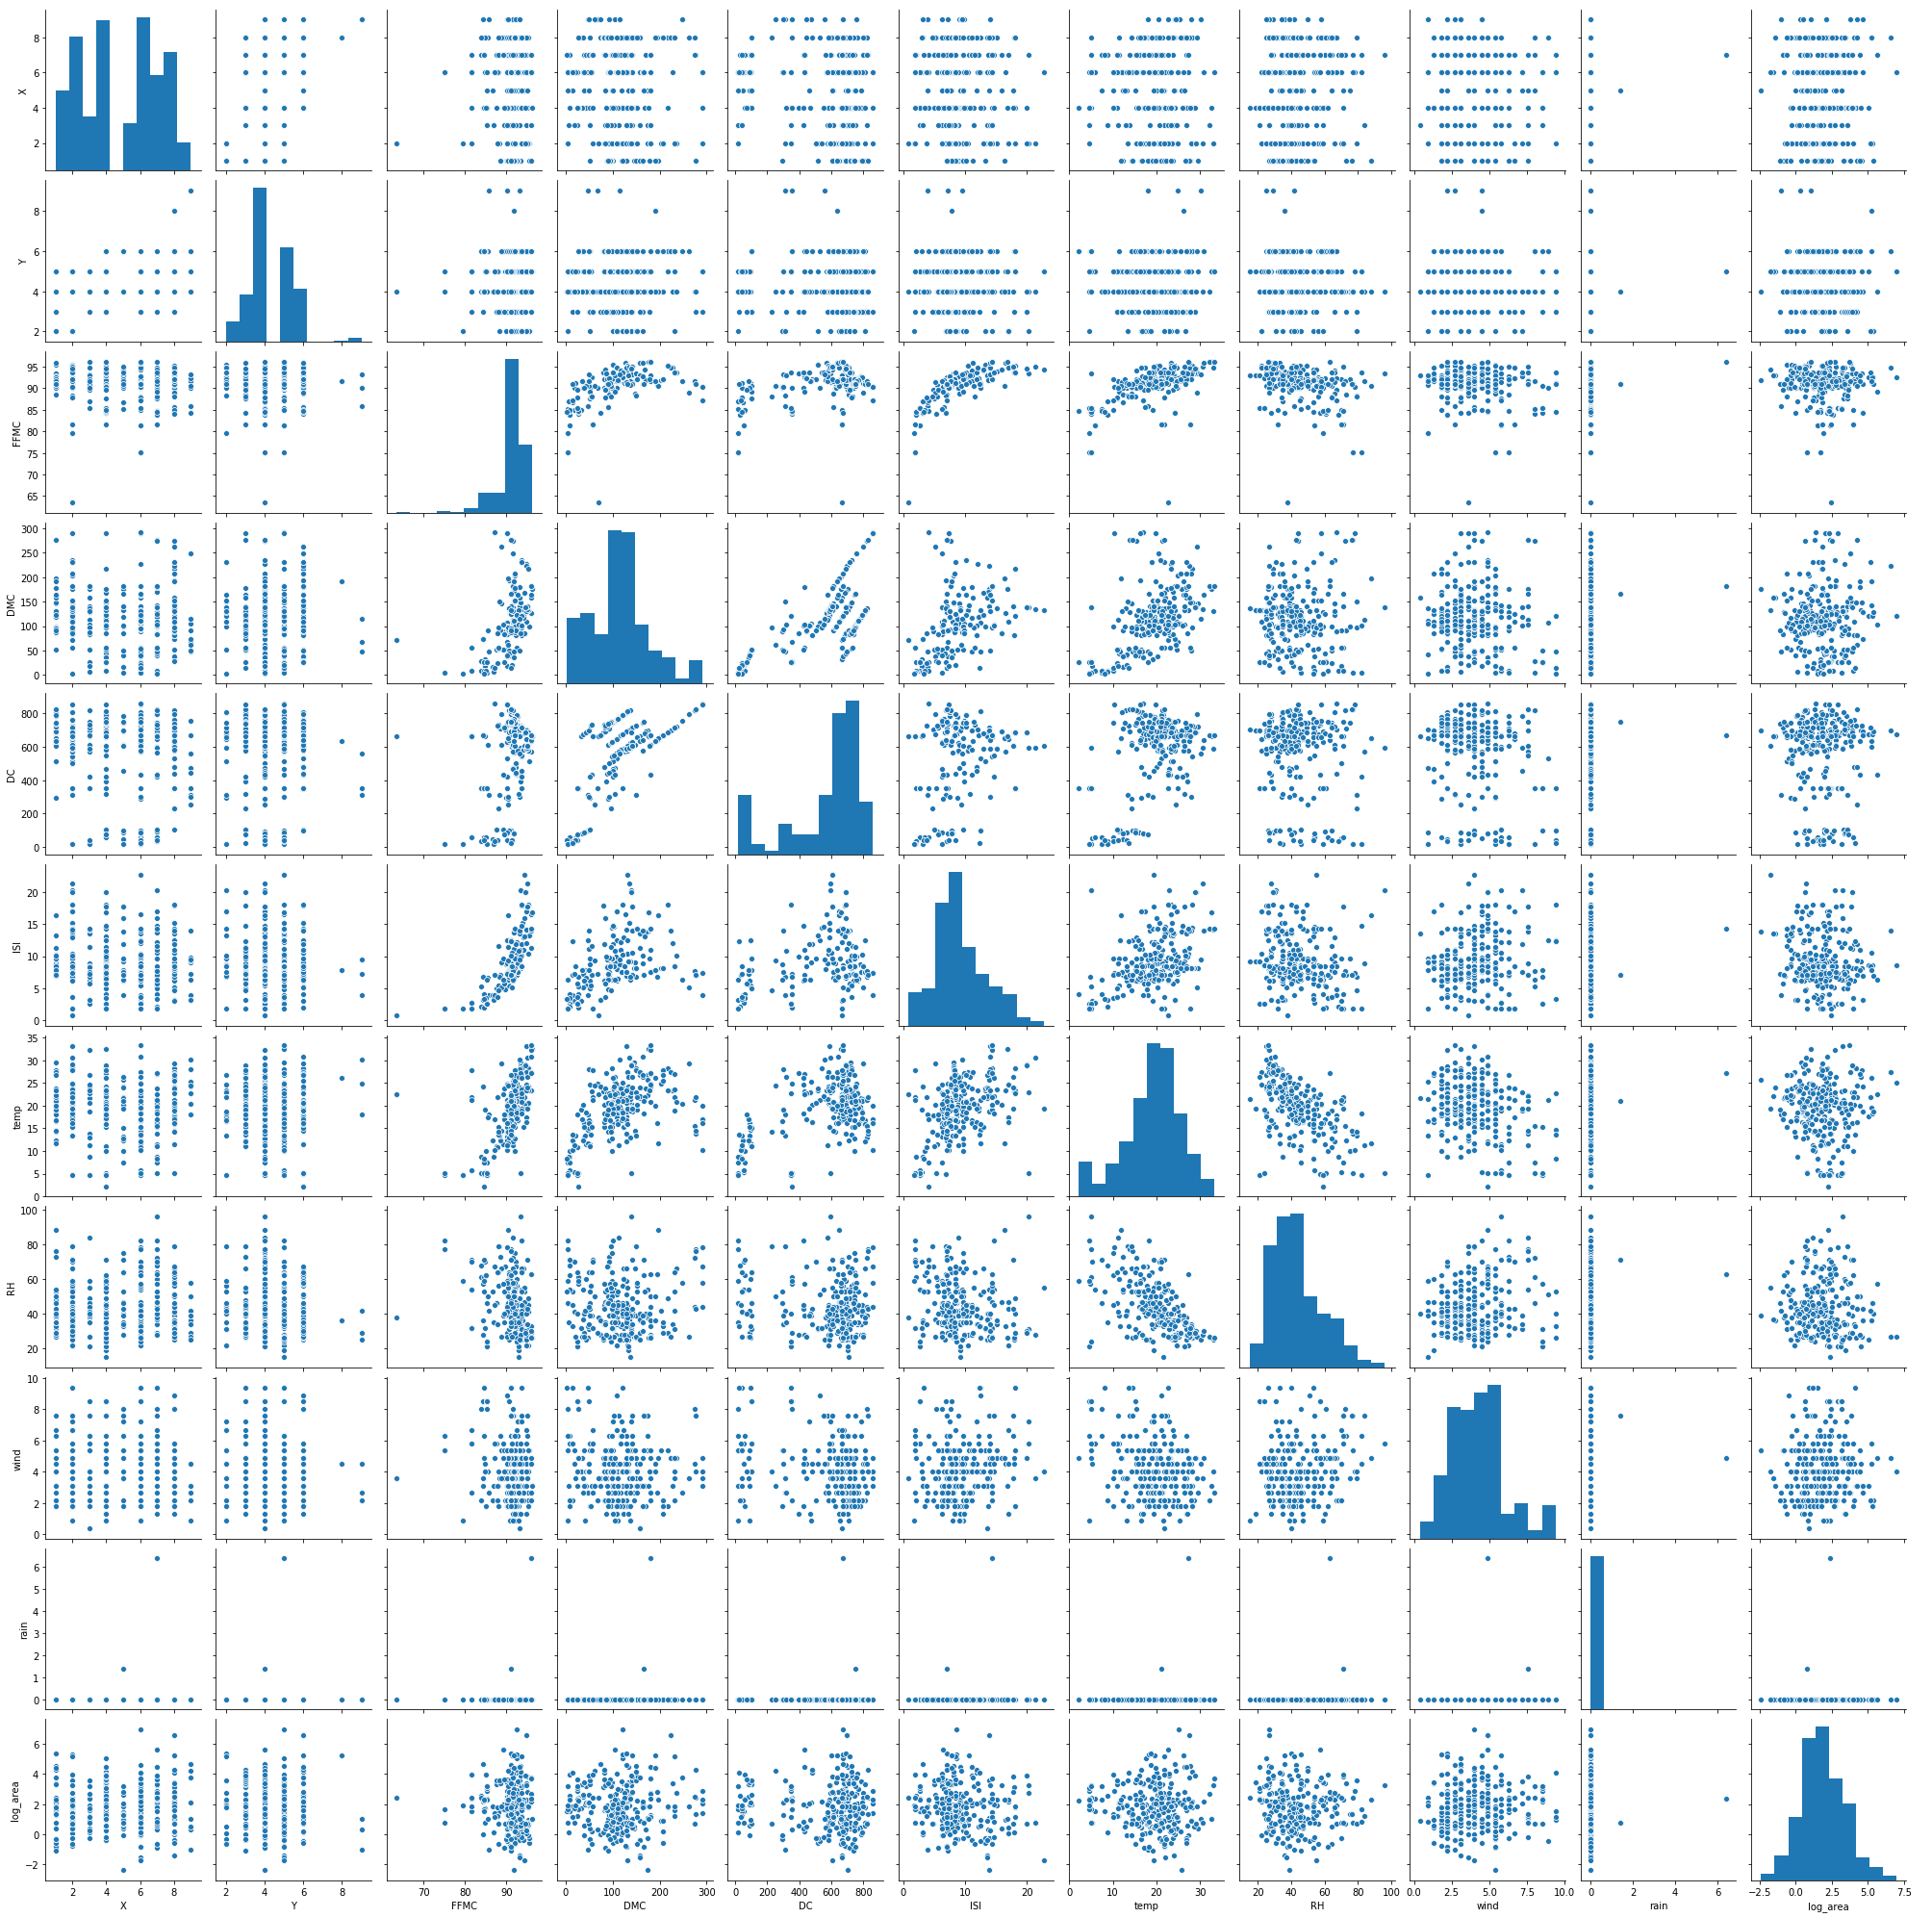

In [4]:
fire_dataframe = fire_dataframe[fire_dataframe["area"] > 0]
fire_dataframe["area"] = numpy.log(fire_dataframe["area"])
fire_dataframe = fire_dataframe.rename(columns = {"area" : "log_area"})
# inspect first rows
print("\nfirst rows:")
print(fire_dataframe.head(10))
# inspect dataframe summary
print("\ndataframe sumary:")
print(fire_dataframe.describe())
# quick scatterplots of unprocessed data
print("\nVisual inspection of data")
print(seaborn.pairplot(fire_dataframe))
# inspect correlations between data
print("\nInspection of correlations")
print(fire_dataframe.corr())

After the filtering, the data still indicates that the area is not correlated with anything. I will proceed with the next step of the data science workflow for training, to assess if this is true at different stages. As a first thing, I renormalize and rescale the data

AxesSubplot(0.125,0.125;0.775x0.755)


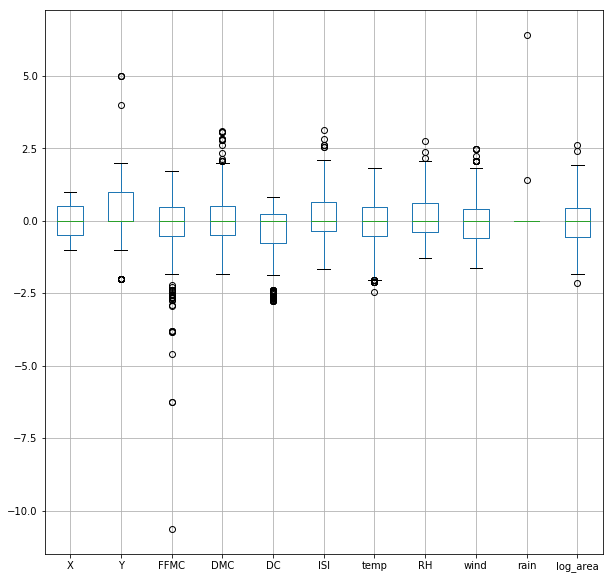

In [5]:
# rescale non-factor variables
temp = fire_dataframe.drop(["month", "day"], axis = 1)
normalized_fire_dataframe = pandas.DataFrame(preprocessing.robust_scale(temp), columns = temp.columns)

# boxplots of continuous variables
dataframe_boxplot_1 = normalized_fire_dataframe.boxplot(figsize=(10, 10))
print(dataframe_boxplot_1)

This indicates that there are outliers, especially in some indicators, but nothing that makes the analysis unmaneagable. Let's check the correlations and the scatterplot again for consistency.

                 X         Y      FFMC       DMC        DC       ISI  \
X         1.000000  0.497039 -0.072176 -0.104614 -0.161281 -0.054832   
Y         0.497039  1.000000 -0.021123  0.037533 -0.034065 -0.071683   
FFMC     -0.072176 -0.021123  1.000000  0.480250  0.407638  0.704170   
DMC      -0.104614  0.037533  0.480250  1.000000  0.668926  0.329656   
DC       -0.161281 -0.034065  0.407638  0.668926  1.000000  0.256826   
ISI      -0.054832 -0.071683  0.704170  0.329656  0.256826  1.000000   
temp     -0.081485  0.031705  0.562256  0.501643  0.495703  0.466027   
RH        0.064763 -0.039081 -0.285990  0.027861 -0.082217 -0.148804   
wind      0.042686 -0.037208 -0.161384 -0.137897 -0.237593  0.072652   
rain      0.055996  0.028215  0.081447  0.075206  0.036377  0.067225   
log_area  0.019832 -0.011719 -0.045433  0.029488 -0.029071 -0.110253   

              temp        RH      wind      rain  log_area  
X        -0.081485  0.064763  0.042686  0.055996  0.019832  
Y         0.0

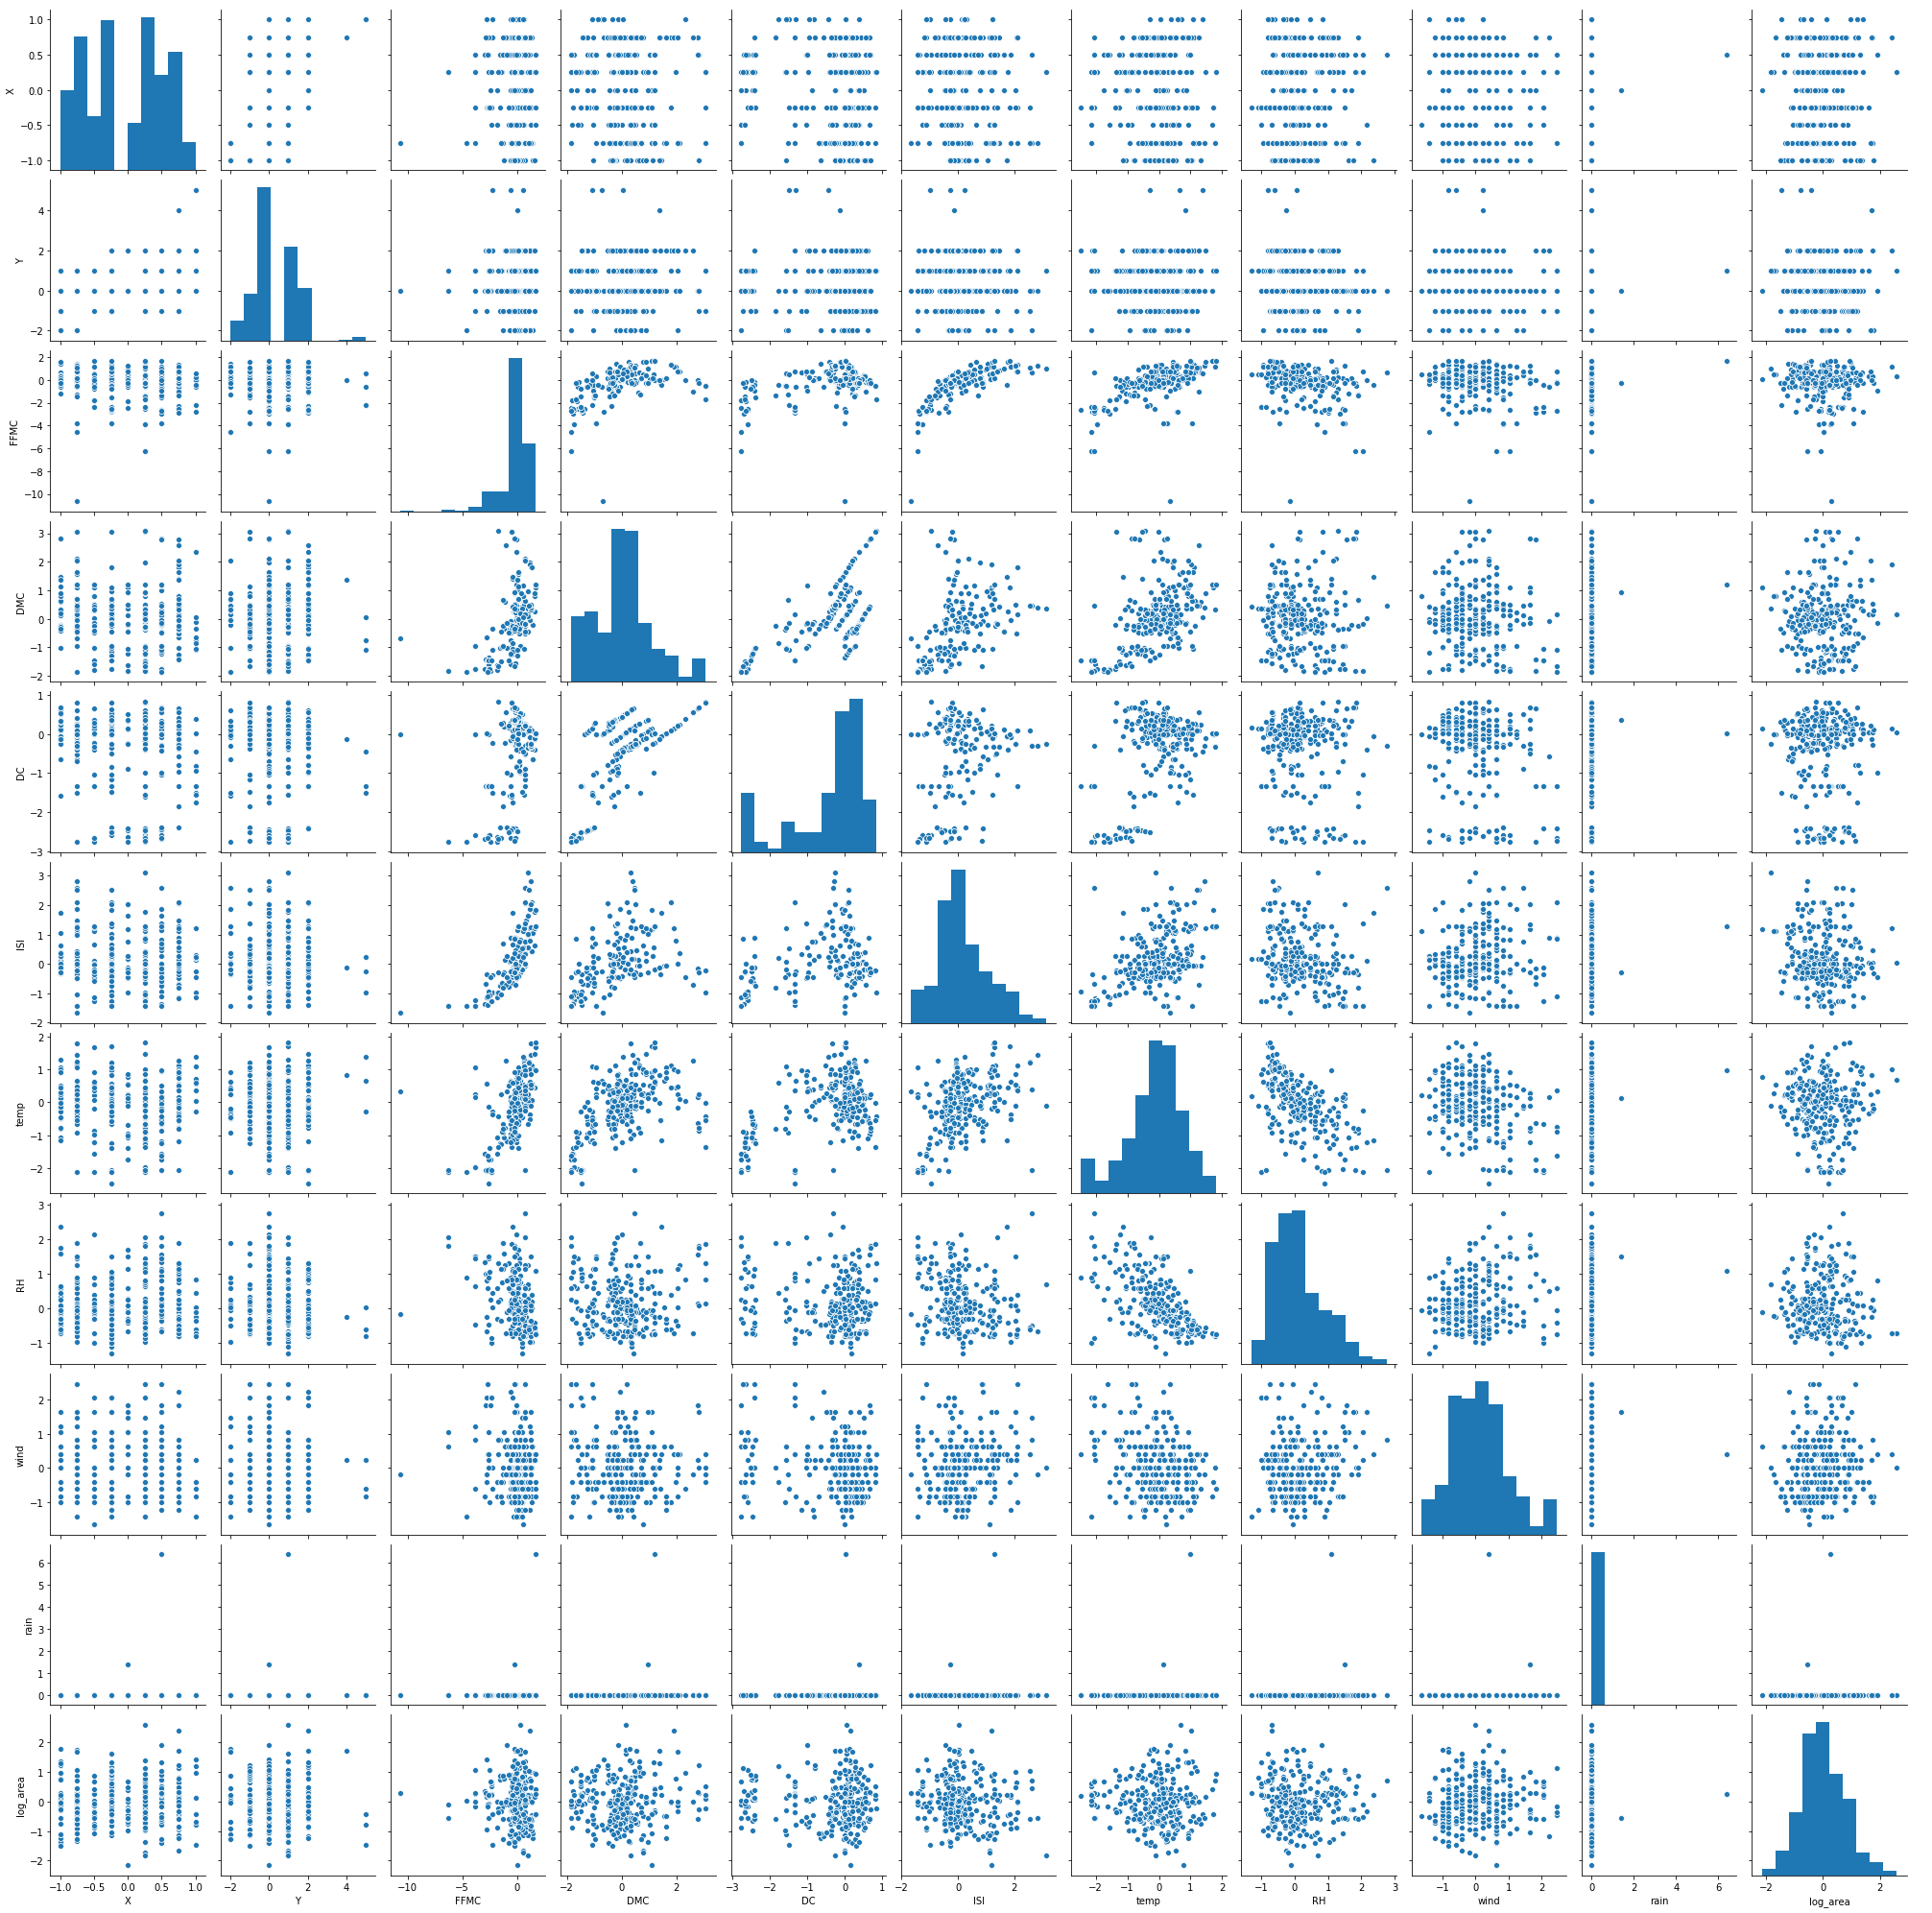

In [6]:
print(seaborn.pairplot(normalized_fire_dataframe))
print(normalized_fire_dataframe.corr())

Yes, there are no clear correlations between the area and the other rescaled variables (which is what I might be interested in). To further corroborate this, I will perform a pricipal component analysis to remove these correlations between the non-area variables. To this end, I first check how much variability of the data I need to explain 75% of the total data variability.

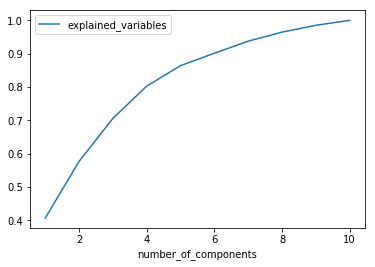

In [7]:
pca_normalized_fire_dataframe = PCA(n_components=10).fit(normalized_fire_dataframe.drop(["log_area"], axis = 1))
explained_variables = pandas.DataFrame({"number_of_components" : range(1,11), "explained_variables" : pca_normalized_fire_dataframe.explained_variance_ratio_.cumsum()})
explained_variables.plot(x = "number_of_components", y = "explained_variables")

Which indicates that I can explain 75% of the data variability with the first 4 principal components. Increasing the number of components does not give additional advantages.

After performing the pca decomposition, I redo the scatterplots and correlation analysis for the PCA dataset

                   PC1           PC2           PC3           PC4  log_area
PC1       1.000000e+00  1.344139e-16 -4.600327e-17 -8.549574e-18  0.044986
PC2       1.344139e-16  1.000000e+00  7.464673e-18 -3.833900e-17 -0.002031
PC3      -4.600327e-17  7.464673e-18  1.000000e+00 -1.652216e-16  0.042121
PC4      -8.549574e-18 -3.833900e-17 -1.652216e-16  1.000000e+00  0.007615
log_area  4.498589e-02 -2.030763e-03  4.212058e-02  7.615429e-03  1.000000


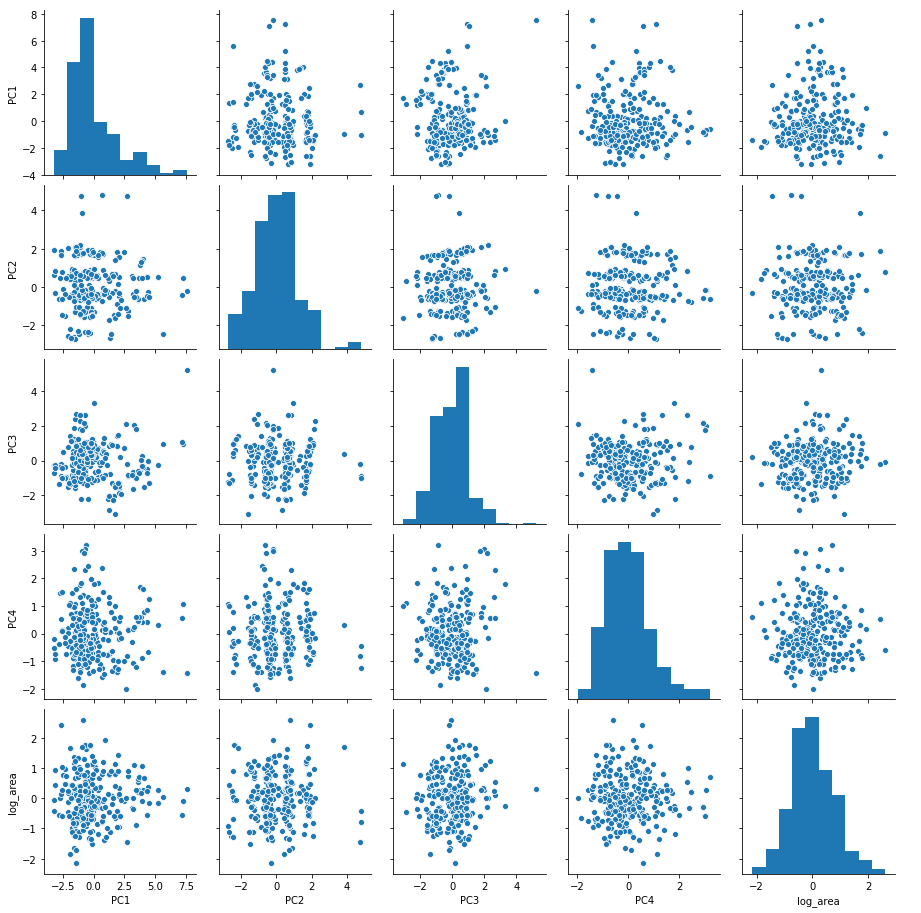

In [8]:
# perform pca
pc_names = ("PC1", "PC2", "PC3", "PC4")
pca_initializer = PCA(n_components=4)
pca_decomposition = pca_initializer.fit_transform(normalized_fire_dataframe.drop(["log_area"], axis = 1))
pca_normalized_fire_dataframe = pandas.DataFrame(pca_decomposition, columns = pc_names)

# recover area infomration
pca_normalized_fire_dataframe["log_area"] = normalized_fire_dataframe["log_area"]

# scatterplots and correlations
print(seaborn.pairplot(pca_normalized_fire_dataframe))
print(pca_normalized_fire_dataframe.corr())


The principal components confirms the initial suspicion: the area seems not to be correlated to any of the explanatory variables we have here. 

This result makes prediction attempts futile, but I want to practive a bit with the prediction algorithms. Therefore I will inspect the PC structure and then perform a linear fit of the area with respect to PC2 and PC3 as an exercise.

In [9]:
pandas.DataFrame(pca_initializer.components_, index = pc_names, columns =normalized_fire_dataframe.drop(["log_area"], axis = 1).columns)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
PC1,0.042402,0.017896,-0.671337,-0.406304,-0.348876,-0.342007,-0.339428,0.122726,0.113328,-0.017472
PC2,0.282431,0.947038,-0.020266,0.077802,0.008146,-0.075729,0.060126,-0.038034,-0.076764,0.011454
PC3,-0.095608,-0.073333,-0.439761,0.506295,0.539519,-0.373455,0.054418,0.192707,-0.255122,-0.004692
PC4,0.062897,0.066876,0.025262,0.340425,0.054108,0.230005,-0.329301,0.502146,0.675037,0.054308


Linear fit procedure

In [10]:
# prepare data to perform the regression model
explanatory_variables = pca_normalized_fire_dataframe[["PC2", "PC3"]].values.reshape(-1,2)
log_area = pca_normalized_fire_dataframe["log_area"].values.reshape(-1,1)

# test-train split 
explanatory_variables_train, explanatory_variables_test, log_area_train, log_area_test = train_test_split(explanatory_variables, log_area, test_size=0.2, random_state=0)

# perform_fit
linear_model = LinearRegression().fit(explanatory_variables_train, log_area_train)
print("\nPerformance evaluation - R^2 score train:")
print(linear_model.score(explanatory_variables_train, log_area_train))
print("\nIntercept:")
print(linear_model.intercept_)
print("\nCoefficients:")
print(pandas.DataFrame(linear_model.coef_, columns = ("PC2", "PC3")))

# evaluate R^2 as a quality measure for the test dataset
print("\nPerformance evaluation - R^2 score test:")
print(linear_model.score(explanatory_variables_test, log_area_test))


Performance evaluation - R^2 score train:
0.00032632262590814864

Intercept:
[-0.0317768]

Coefficients:
       PC2       PC3
0  0.00645  0.010813

Performance evaluation - R^2 score test:
-0.0345073396166129
